In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import glob

Notebook for creating complete HRDPS file after downscaling, for every variable. Produces reconstructed daily HRDPS files and publishes them to the desired filepath.

## Importing Training Data

| Description | HRDPS       | CANRCM      | 
| ----------- | ----------- | ----------- |
| Near-Surface Air Temperature | tair | tas |
| Precipitation | precip | pr |
| Sea Level Pressure | atmpres | psl |
| Near Surface Specific Humidity | qair | huss |
| Shortwave radiation | solar | rsds |
| Longwave radiation | therm_rad | rlds |

In [2]:
variables = [['tair', 'tas', 'Near-Surface Air Temperature'], 
             ['precip', 'pr', 'Precipitation'], 
             ['atmpres', 'psl', 'Sea Level Pressure'], 
             ['qair', 'huss', 'Near Surface Specific Humidity'], 
             ['solar', 'rsds', 'Shortwave radiation'], 
             ['therm_rad', 'rlds', 'Longwave radiation']]

In [17]:
def import_HRDPS(year, variable):
    ##file paths
    data_name_hr = variable[0]
    files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y' + str(year) + 'm??d??.nc')
    files.sort()
    
    ## 3-hour averaged data
    hr = np.zeros( (8*len(files), 266, 256))  
    
    for i in range(len(files)):
        dayX = xr.open_dataset(files[i])
        ##adding 1 day of 3-hour averages to new data array
        hr[8*i:8*i + 8,:,:] = np.array( dayX[ data_name_hr ] ).reshape(8, 3, 266, 256).mean(axis = 1)
    return hr
            
def import_CANRCM(year, variable):
    data_name_can = variable[1]
    p_can = '/ocean/arandhawa/canrcm_' + data_name_can + '_' + str(year) + '.nc'
    ##CANRCM import
    d1 = xr.open_dataset(p_can)
    if year == 2007:
        can = d1[data_name_can][16:,140:165,60:85] ##the first two days are removed to be consistent with 2007 HRDPS
    elif year == 2008:
        can = np.concatenate((d1[data_name_can][:472,140:165,60:85], d1[data_name_can][464:472,140:165,60:85], d1[data_name_can][472:,140:165,60:85] ))
    else:
        can = d1[data_name_can][:,140:165,60:85]
    return can

In [19]:
def import_HRDPS_winds(year):
    
    ##file paths
    files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y' + str(year) + 'm??d??.nc')
    files.sort()
    ## calculating 3-hour averaged data
    hr07_u = np.zeros( (8*len(files), 266, 256)) 
    hr07_v = np.zeros( (8*len(files), 266, 256)) 

    for i in range(len(files)):
        dayX = xr.open_dataset(files[i])
        u = np.array( dayX['u_wind'] ).reshape(8, 3, 266, 256)
        v = np.array( dayX['v_wind'] ).reshape(8, 3, 266, 256)
        
        ##averaging magnitudes/directions rather than averaging conponents
        avg_spd = np.mean(np.sqrt(u**2 + v**2), axis = 1)
        avg_th = np.arctan2(v.mean(axis = 1), u.mean(axis = 1))
        avg_u = avg_spd*np.cos(avg_th)
        avg_v = avg_spd*np.sin(avg_th) 
        
        hr07_u[8*i:8*i + 8, : , : ] = avg_u ##adding 3-hour average to new data array
        hr07_v[8*i:8*i + 8, : , : ] = avg_v
    del avg_u
    del avg_v
    del u
    del v
    del avg_spd
    del avg_th
    
    return (hr07_u, hr07_v)

def import_CANRCM_winds(year):
    
    ##data paths
    p_can_u = '/ocean/arandhawa/canrcm_uas_' + str(year) + '.nc'
    p_can_v = '/ocean/arandhawa/canrcm_vas_' + str(year) + '.nc'
    ##importing data
    d1 = xr.open_dataset(p_can_u)
    d2 = xr.open_dataset(p_can_v)
    
    if year == 2007:
        can_u = d1['uas'][16:,140:165,60:85] ##the first two days are removed to be consistent with 2007 HRDPS
        can_v = d2['vas'][16:,140:165,60:85]
    elif year == 2008:
        can_u = np.concatenate((d1['uas'][:472,140:165,60:85], d1['uas'][464:472,140:165,60:85], d1['uas'][472:,140:165,60:85] ))
        can_v = np.concatenate((d2['vas'][:472,140:165,60:85], d2['vas'][464:472,140:165,60:85], d2['vas'][472:,140:165,60:85] ))
        ##repeating feb 28th twice for leap year
    else:
        can_u = d1['uas'][:,140:165,60:85]
        can_v = d2['vas'][:,140:165,60:85]
        
    return (can_u, can_v)

## PCA Functions

In [5]:
##transforms and concatenates two data sets
def transform2(data1, data2):
    A_mat = transform(data1)
    B_mat = transform(data2)
    return np.concatenate((A_mat, B_mat), axis=0) 

In [6]:
##inverse function of transform2 - splits data matrix and returns two data sets
def reverse2(matrix, orig_shape):
    split4 = int( matrix.shape[0]/2 )
    u_data = reverse(matrix[:split4,:], orig_shape) ##reconstructing u_winds from n PCs
    v_data = reverse(matrix[split4:,:], orig_shape) ##reconstructing v_winds from n PCs
    return (u_data, v_data)

In [7]:
##performs PCA analysis using sklearn.pca
def doPCA(comp, matrix):
    pca = PCA(n_components = comp) ##adjust the number of principle conponents to be calculated
    PCs = pca.fit_transform(matrix)
    eigvecs = pca.components_
    mean = pca.mean_
    return (PCs, eigvecs, mean)

In [8]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr) ##converting to numpy array
    arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2]) ##reshaping from size (a, b, c) to (a, b*c)
    arr = arr.transpose()
    return arr

def reverse(mat, orig_shape):
    arr = np.copy(mat)
    arr = arr.transpose()
    arr = arr.reshape(-1, orig_shape[1], orig_shape[2]) ##reshaping back to original array shape
    return arr

In [9]:
##graphing percentage of original data represented by the first n principle conponents
def graph_variance(matrix, n):
    pcaG = PCA(n_components = n) ##Number of principle conponents to show
    PCsG = pcaG.fit_transform(matrix)
    plt.plot(np.cumsum(pcaG.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()
    del pcaG
    del PCsG

In [10]:
##can be used to visualize principle conponents for u/v winds
def graph_nPCs(PCs, eigvecs, n, orig_shape):
    fig, ax = plt.subplots(n, 3, figsize=(10, 3*n))
    
    ax[0, 0].set_title("u-conponent")
    ax[0, 1].set_title("v-component")
    ax[0, 2].set_title("time-loadings")
    
    for i in range(n):
        mode_u, mode_v = get_mode(PCs, i, orig_shape)
        colors = ax[i, 0].pcolormesh(mode_u, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,0])
        colors = ax[i, 1].pcolormesh(mode_v, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,1])
        ax[i, 2].plot(eigvecs[i])

    plt.tight_layout()
    plt.show()

##converts PCs (column vectors) to 2d conpoents for u and v wind
def get_mode(PCs, n, orig_shape): 
    split = int(PCs.shape[0]/2)
    mode_u = PCs[:split, n].reshape(orig_shape[1], orig_shape[2])
    mode_v = PCs[split:, n].reshape(orig_shape[1], orig_shape[2])
    return (mode_u, mode_v)



## Multiple Linear Regression Functions

In [11]:
##functions that use multiple linear regression to fit eigenvectors
##takes CANRCM eigenvectors (x1, x2, x3, x4...) and HRDPS eigenvectors (y1, y2, y3...)
##For each y from 0:result_size, approximates yn = a0 + a1*x1 + a2*x2 + a3*x3 ... using num_vec x's
##getCoefs returns (coeficients, intercept)
##fit_modes returns each approximation and the R^2 value of each fit as (results, scores)

def getCoefs(vectors, num_vec, data, num_modes, type = 'LS'):  
    
    X = vectors[0:num_vec,:].T
    coefs = np.zeros((num_modes, X.shape[1]))
    intercept = np.zeros(num_modes)
    
    if type == 'LS':
        for i in range(num_modes):
            y = data[i,:]
            reg = LinearRegression().fit(X, y)
            coefs[i] = reg.coef_[0:num_vec]
            intercept[i] =  reg.intercept_
    elif type == 'MAE':
        for i in range(num_modes):
            y = data[i,:]
            reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
            coefs[i] = reg.coef_[0:num_vec]
            intercept[i] =  reg.intercept_
    
    return (coefs, intercept)


def fit_modes(vectors, num_vec, data, result_size, type = 'LS'):  
    
    X = vectors[0:num_vec,:].T
    result = np.zeros((result_size, X.shape[0]))
    scores = np.zeros(result_size)
    
    if type == 'LS':
        for i in range(result_size):
            y = data[i,:]
            reg = LinearRegression().fit(X, y)
            result[i] = reg.predict(X)
            scores[i] = reg.score(X, y)
            
    elif type == 'MAE':
        for i in range(result_size):
            y = data[i,:]
            reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
            result[i] = reg.predict(X)
            scores[i] = reg.score(X, y)
    
    return (result, scores)


In [12]:
##returns the ratio of the average energy between two sets of eigenvectors (element-wise)
##"energy" is defined as value^2 - two sets of eigenvectors with the same "energy" would
##recreate data with approximately the same kinetic energy (v^2)

def getEnergyCoefs(eigs, old_eigs):
    coefs = np.sqrt( (old_eigs[0:eigs.shape[0]]**2).mean(axis = 1)/(eigs**2).mean(axis = 1))
    return coefs

## Projection Function

In [13]:
##scalar projection of u onto v - with extra 1/norm factor (for math reasons)
##projectData projects the data onto each principle conponent, at each time
##output is a set of eigenvectors

def project(u, v):  
    v_norm = np.sqrt(np.sum(v**2))    
    return np.dot(u, v)/v_norm**2

def projectData(data_mat, new_PCs, n):
    time = data_mat.shape[1]
    proj = np.empty((n, time))

    for j in range(n):
        for i in range(time):
            proj[j, i] = project(data_mat[:,i], new_PCs[:,j])
            
    return proj

## Overall Function

In [14]:
def reconstruct(downscale_mat, mean, can_PCs, can_me, hr_PCs, hr_me, n, r, method = 'LS', EB = 'False'):

    coefs = getCoefs(can_me, n + 1, hr_me, r + 1, type = method)
    proj = np.concatenate((mean.reshape(1, -1), projectData(downscale_mat - mean, can_PCs, n)), axis = 0)
    pred_eigs = np.matmul(coefs[0], proj) + coefs[1].reshape(-1, 1)  ##multiple linear regression output
    if (EB == 'true'):
        energyCoefs = getEnergyCoefs( fit_modes(can_me, n + 1, hr_me, r + 1, type = method)[0], hr_me)
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    if (EB == 'function'):
        energyCoefs = getEnergyCoefs( fit_modes(can_me, n + 1, hr_me, r + 1, type = method)[0] , hr_me)
        def f(x):
            return np.exp(-x/50)
        for x in range(r + 1):
            energyCoefs = (energyCoefs - 1)*f(x) + 1
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    
    recon = np.matmul(hr_PCs[:,0:r], pred_eigs[1:r+1]) + pred_eigs[0]
    data_rec = reverse(recon, (-1, 266, 256))
    if (EB == 'constant'):
        data_rec *= 1.25
    
    return data_rec

In [15]:
def reconstruct2(downscale_mat, mean, can_PCs, can_me, hr_PCs, hr_me, n, r, method = 'LS', EB = 'false'):

    coefs = getCoefs(can_me, n + 1, hr_me, r + 1, type = method)
    proj = np.concatenate((mean.reshape(1, -1), projectData(downscale_mat - mean, can_PCs, n)), axis = 0)
    pred_eigs = np.matmul(coefs[0], proj) + coefs[1].reshape(-1, 1)  ##multiple linear regression output
    if (EB == 'true'):
        energyCoefs = getEnergyCoefs( fit_modes(can_me, n + 1, hr_me, r + 1, type = method)[0], hr_me)
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    if (EB == 'function'):
        energyCoefs = getEnergyCoefs( fit_modes(can_me, n + 1, hr_me, r + 1, type = method)[0] , hr_me)
        def f(x):
            return np.exp(-x/50)
        for x in range(r + 1):
            energyCoefs = (energyCoefs - 1)*f(x) + 1
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    
    recon = np.matmul(hr_PCs[:,0:r], pred_eigs[1:r+1]) + pred_eigs[0]
    u_data_rec, v_data_rec = reverse2(recon, (-1, 266, 256))
    if (EB == 'constant'):
        u_data_rec *= 1.3
        v_data_rec *= 1.3
    
    return (u_data_rec, v_data_rec)

## Reconstructing Complete Dataset

In [16]:
data = ()

##reconstructing u and v winds
hr07_u, hr07_v = import_HRDPS_winds(2007)

In [20]:
can07_u, can07_v = import_CANRCM_winds(2007)
##PCA on CANRCM 2007
can07_mat = transform2(can07_u, can07_v)
can07_PCs, can07_eigs, can07_mean = doPCA(100, can07_mat)

##PCA on HRDPS 2007
hr07_mat = transform2(hr07_u, hr07_v)
hr07_PCs, hr07_eigs, hr07_mean = doPCA(100, hr07_mat)

## combining the eigenvectors and mean together in one array for analysis
can07_me = np.concatenate((can07_mean.reshape(1, -1), can07_eigs))
hr07_me = np.concatenate((hr07_mean.reshape(1, -1), hr07_eigs))

##calculating average of rows
mean_2007 = can07_mat.mean(axis = 0)

u_data_rec, v_data_rec = reconstruct2(can07_mat, mean_2007, can07_PCs, can07_me, hr07_PCs, hr07_me, 65, 65, method = 'LS')

In [33]:
scale_uv = (u_data_rec**2 + v_data_rec**2).mean(axis=0)/(hr07_u**2 + hr07_v**2).mean(axis=0)
scale_u = (u_data_rec**2).mean(axis=0)/(hr07_u**2).mean(axis=0)
scale_v = (v_data_rec**2).mean(axis=0)/(hr07_v**2).mean(axis=0)

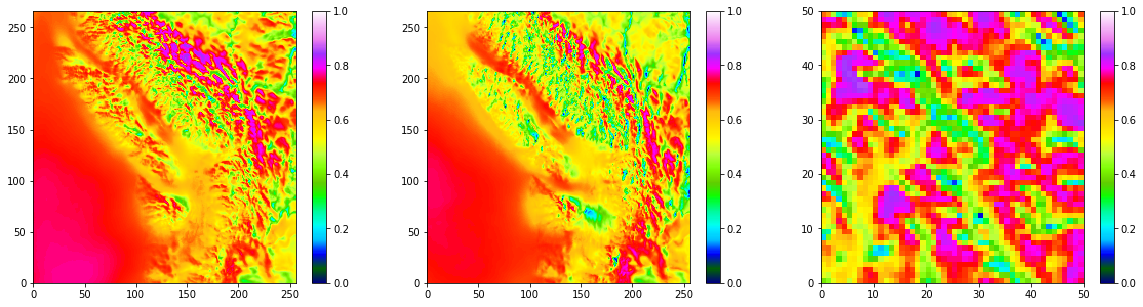

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].pcolormesh(scale_uv, vmin=0, vmax=1, cmap='gist_ncar')
axs[1].pcolormesh(scale_u, vmin=0, vmax=1, cmap='gist_ncar')
colours = axs[2].pcolormesh(scale_v[150:200, 150:200], vmin=0, vmax=1, cmap='gist_ncar')
for ax in axs:
    fig.colorbar(colours, ax=ax);

In [45]:
u_data_new = u_data_rec / np.sqrt(scale_u)
v_data_new = v_data_rec / np.sqrt(scale_v)

1.2434897306315909
1.207115304412467
1.9090918309074025


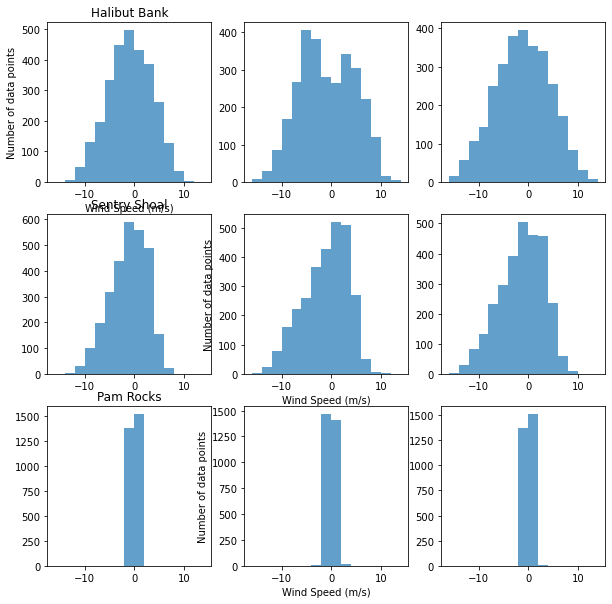

In [66]:
nums = np.arange(0, 37, 2)
nums2 = np.arange(-16, 16, 2)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

ax[0, 0].set_title("Halibut Bank")
ax[0, 1].hist(hr07_u[:,142,139], bins = nums2, label = "HRDPS", alpha = 0.7)
ax[0, 0].hist(u_data_rec[:,142,139], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[0, 2].hist(u_data_new[:,142,139], bins = nums2, label = "Reconstructed2", alpha = 0.7)
ax[0, 0].set_xlabel("Wind Speed (m/s)")
ax[0, 0].set_ylabel("Number of data points")
print (1/np.sqrt(scale_u[142,139]))
#ax[0, 0].legend()

ax[1, 0].set_title("Sentry Shoal")
ax[1, 1].hist(hr07_u[:, 174, 107], bins = nums2, label = "HRDPS", alpha = 0.7)
ax[1, 0].hist(u_data_rec[:,174,107], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[1, 2].hist(u_data_new[:,174,107], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[1, 1].set_xlabel("Wind Speed (m/s)")
ax[1, 1].set_ylabel("Number of data points")
print (1/np.sqrt(scale_u[174,107]))
#ax[1, 1].legend()

ax[2, 0].set_title("Pam Rocks")
ii, jj = 153, 154
ax[2, 1].hist(hr07_u[:, ii, jj], bins = nums2, label = "HRDPS", alpha = 0.7)
ax[2, 0].hist(u_data_rec[:,ii, jj], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[2, 2].hist(u_data_new[:,ii, jj], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[2, 1].set_xlabel("Wind Speed (m/s)")
ax[2, 1].set_ylabel("Number of data points")
print (1/np.sqrt(scale_u[ii, jj]))
#ax[1, 1].legend()

1.3689652618804253
1.2152862305382575
1.3752385837592598


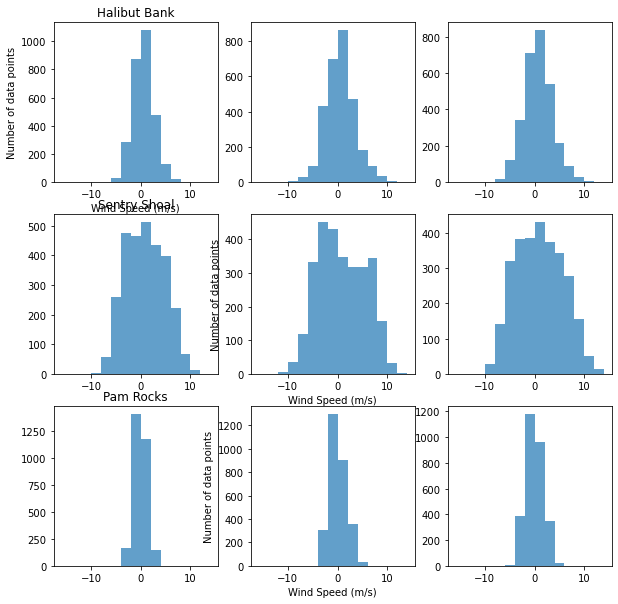

In [67]:
nums = np.arange(0, 37, 2)
nums2 = np.arange(-16, 16, 2)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

ax[0, 0].set_title("Halibut Bank")
ax[0, 1].hist(hr07_v[:,142,139], bins = nums2, label = "HRDPS", alpha = 0.7)
ax[0, 0].hist(v_data_rec[:,142,139], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[0, 2].hist(v_data_new[:,142,139], bins = nums2, label = "Reconstructed2", alpha = 0.7)
ax[0, 0].set_xlabel("Wind Speed (m/s)")
ax[0, 0].set_ylabel("Number of data points")
print (1/np.sqrt(scale_v[142,139]))
#ax[0, 0].legend()

ax[1, 0].set_title("Sentry Shoal")
ax[1, 1].hist(hr07_v[:, 174, 107], bins = nums2, label = "HRDPS", alpha = 0.7)
ax[1, 0].hist(v_data_rec[:,174,107], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[1, 2].hist(v_data_new[:,174,107], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[1, 1].set_xlabel("Wind Speed (m/s)")
ax[1, 1].set_ylabel("Number of data points")
print (1/np.sqrt(scale_v[174,107]))
#ax[1, 1].legend()

ax[2, 0].set_title("Pam Rocks")
ii, jj = 153, 154
ax[2, 1].hist(hr07_v[:, ii, jj], bins = nums2, label = "HRDPS", alpha = 0.7)
ax[2, 0].hist(v_data_rec[:,ii, jj], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[2, 2].hist(v_data_new[:,ii, jj], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[2, 1].set_xlabel("Wind Speed (m/s)")
ax[2, 1].set_ylabel("Number of data points")
print (1/np.sqrt(scale_v[ii, jj]))
#ax[1, 1].legend()

In [68]:
print (np.sqrt(((1.25*u_data_rec - hr07_u)**2).mean()))

1.9240085046943507


In [69]:
print (np.sqrt(((u_data_new - hr07_u)**2).mean()))

1.897721900766717


In [70]:
print (np.sqrt(((1.25*v_data_rec - hr07_v)**2).mean()))

2.0260627740902826


In [71]:
print (np.sqrt(((v_data_new - hr07_v)**2).mean()))

1.9569941193660578


In [67]:
u_data_rec *= 1.25
v_data_rec *= 1.25
data += (('u_wind', u_data_rec),)
data += (('v_wind', v_data_rec),)
print("u and v winds done")

del can07_u
del can07_v
del hr07_u
del hr07_v
del can07_mat
del can07_PCs
del can07_eigs
del can07_me
del can07_mean
del u_data_rec
del v_data_rec
del hr07_mat
del hr07_PCs
del hr07_eigs
del hr07_me
del hr07_mean

u and v winds done


In [71]:
##reconstructing other variables
for i in variables:

    hr07 = import_HRDPS(2007, i)
    can07 = import_CANRCM(2007, i)
    
    ##PCA on CANRCM 2007
    can07_mat = transform(can07)
    can07_PCs, can07_eigs, can07_mean = doPCA(100, can07_mat)

    ##PCA on HRDPS 2007
    hr07_mat = transform(hr07)
    hr07_PCs, hr07_eigs, hr07_mean = doPCA(100, hr07_mat)

    ## combining the eigenvectors and mean together in one array for analysis
    can07_me = np.concatenate((can07_mean.reshape(1, -1), can07_eigs))
    hr07_me = np.concatenate((hr07_mean.reshape(1, -1), hr07_eigs))

    ##calculating average of rows
    mean_2007 = can07_mat.mean(axis = 0)

    data_rec = reconstruct(can07_mat, mean_2007, can07_PCs, can07_me, hr07_PCs, hr07_me, 65, 65, method = 'LS')
    
    data_name_hr = i[0]
    if data_name_hr == 'precip' or data_name_hr == 'qair' or data_name_hr == 'solar' or data_name_hr == 'therm_rad':
        avg = np.mean(data_rec, axis = 0)
        data_rec[data_rec < 0] = 0
        avg2 = np.mean(data_rec, axis = 0)
        data_rec *= avg/avg2
    if data_name_hr == 'solar':
        night_solar = np.mean(data_rec[2::8], axis = 0)
        data_rec[data_rec < night_solar + 0.1] = 0 
        
    
    data += ((data_name_hr, data_rec),)
    print(data_name_hr, "done")
del can07
del hr07
del can07_mat
del can07_PCs
del can07_eigs
del hr07_mat
del hr07_PCs
del hr07_eigs
del can07_me
del hr07_me
del data_rec

tair done
precip done
atmpres done
qair done
solar done
therm_rad done


In [72]:
##creating netcdf files for each day and publishing them to the given path
##creates a netcdf file for each day

data_var = {}
dims = ('time_counter', 'y', 'x')
times = np.arange('2007-01-03T00:00', '2008-01-01T00:00', np.timedelta64(3, 'h'), dtype='datetime64[ns]')

for i in range(363):
    for j in data:
        data_var[ j[0] ] = (dims, j[1][8*i:8*i + 8], {})
    coords = {'time_counter': times[8*i:8*i + 8], 'y': range(266), 'x': range(256)}
    ds = xr.Dataset(data_var, coords)
    
    d = pd.to_datetime(times[8*i])
    if d.month < 10:
        month = '0' + str(d.month)
    else:
        month = str(d.month)
    if d.day < 10:
        day = '0' + str(d.day)
    else:
        day = str(d.day)
    path = '/ocean/arandhawa/reconstructed_data_2007_p3/recon_y2007m' + month + 'd' + day + '.nc'
    
    encoding = {var: {'zlib': True} for var in ds.data_vars}
    ds.to_netcdf(path, unlimited_dims=('time_counter'), encoding=encoding)
    print("# of files complete: ", i, end = '/r')

In [74]:
files = glob.glob('/ocean/arandhawa/reconstructed_data_2007_p3/recon_*')
len(files)

363